In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
df = pd.read_csv('/content/drive/My Drive/normalizedxgboostv2.csv')


In [12]:
X = df.drop('target', axis=1)
y = df['target']
# X are the features Y  the labl to predict

In [13]:
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Train set: (5235, 1429)
Test set: (1309, 1429)


we aply pca first to reduce the dimensionality of the dataset

test of xgboost training

In [14]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\nScale pos weight: {scale_pos_weight:.2f}")

# Paramètres de base
base_params = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'auc'],
    'tree_method': 'hist',
    'scale_pos_weight': scale_pos_weight,
    'random_state': 42
}



Scale pos weight: 0.97


In [15]:
param_grid = {
    'max_depth': [30, 50],
    'learning_rate': [0.025, 0.1],
    'n_estimators': [100, 200],
    'min_child_weight': [3],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0.025]
}


In [16]:
tscv = TimeSeriesSplit(n_splits=14)

# Modèle de base pour grid search
xgb_model = xgb.XGBClassifier(**base_params)

In [17]:
print("\nRecherche des meilleurs hyperparamètres...")
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)


Recherche des meilleurs hyperparamètres...


execute grid search

In [18]:
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"\nMeilleurs paramètres: {best_params}")

Fitting 14 folds for each of 8 candidates, totalling 112 fits

Meilleurs paramètres: {'colsample_bytree': 0.8, 'gamma': 0.025, 'learning_rate': 0.025, 'max_depth': 30, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


In [19]:
final_model = xgb.XGBClassifier(
    **base_params,
    **best_params,
    early_stopping_rounds=30
)

# Entraînement avec validation
eval_set = [(X_train, y_train), (X_test, y_test)]
final_model.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=50
)

[0]	validation_0-logloss:0.68394	validation_0-auc:0.83630	validation_1-logloss:0.69315	validation_1-auc:0.50765
[50]	validation_0-logloss:0.38202	validation_0-auc:1.00000	validation_1-logloss:0.69270	validation_1-auc:0.52851
[100]	validation_0-logloss:0.24320	validation_0-auc:1.00000	validation_1-logloss:0.69317	validation_1-auc:0.53795
[131]	validation_0-logloss:0.19298	validation_0-auc:1.00000	validation_1-logloss:0.69499	validation_1-auc:0.53646


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=30,
              enable_categorical=False, eval_metric=['logloss', 'auc'],
              feature_types=None, feature_weights=None, gamma=0.025,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)


RÉSULTATS DU MODÈLE
Accuracy: 0.5286
ROC-AUC: 0.5385

Classification Report:
              precision    recall  f1-score   support

        Down       0.50      0.49      0.50       618
          Up       0.55      0.56      0.56       691

    accuracy                           0.53      1309
   macro avg       0.53      0.53      0.53      1309
weighted avg       0.53      0.53      0.53      1309



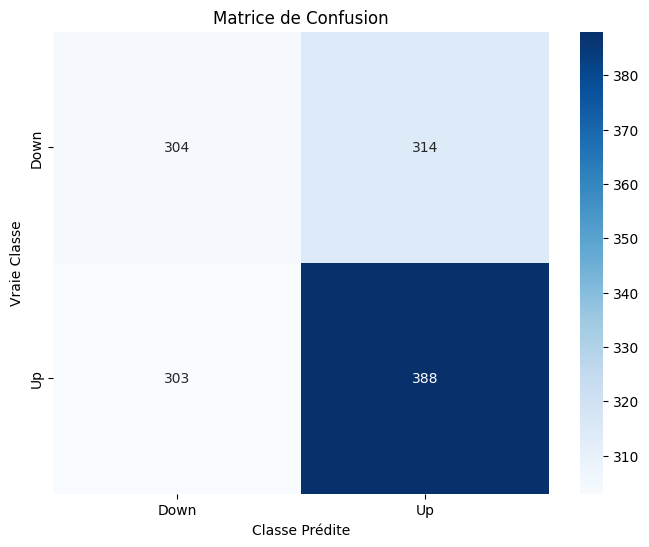

In [20]:
# Prédictions
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Métriques
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\n" + "="*50)
print("RÉSULTATS DU MODÈLE")
print("="*50)
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Down', 'Up']))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.title('Matrice de Confusion')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')
plt.show()



In [21]:
booster = final_model.get_booster()
booster.save_model("/content/drive/MyDrive/final_xgb_bin2.json")